In [70]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2
import sys
import os
import glob
import re
from skimage.filters import gaussian
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import preprocessing
from pandas import DataFrame
import selectivesearch

sys.path.append(r"D:\Projects\LEGO Vision\Helpers")
import helpers
only_numbers = re.compile(r"\d+\.\d+")

In [2]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

In [53]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [97]:
def display_bounding_boxes(image, bounding_boxes, labels=None, scores=None):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image)
    for index, box in enumerate(bounding_boxes):
        x1, y1, x2, y2 = box
        rect = mpatches.Rectangle((x1, y1), abs(x2 - x1), abs(y2 - y1), fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        if labels and scores:
            ax.annotate(f"{labels[index]} {scores[index] * 100:.2f}%", (x1, y1))
        elif labels:
            ax.annotate(f"{labels[index]}", (x1, y1))

In [313]:
def resize_and_pad(img, width, height, pad_value=114):
    img_width = len(img[0])
    img_height = len(img)
    scale_w = img_width > img_height
    target_w = width
    target_h = height
    scale = None
    if scale_w:
        scale = float(width) / float(img_width)
        target_h = int(np.round(img_height * scale))
    else:
        scale = float(height) / float(img_height)
        target_w = int(np.round(img_width * scale))

    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)

    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    bottom = height - top - target_h
    right = width - left - target_w
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])
    return resized_with_pad, scale, (left, top, right, bottom)

In [206]:
image_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.jpg"
bbox_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.bboxes.tsv"
labels_path = r"D:\LEGO Vision Datasets\Detection\Natural Data_output\testImages\IMG_20181105_092359.bboxes.labels.tsv"

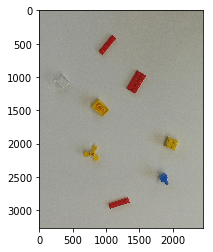

In [207]:
# resized = resize_and_pad(cv2.imread(image_path), width=1024, height=1024)[0]
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)

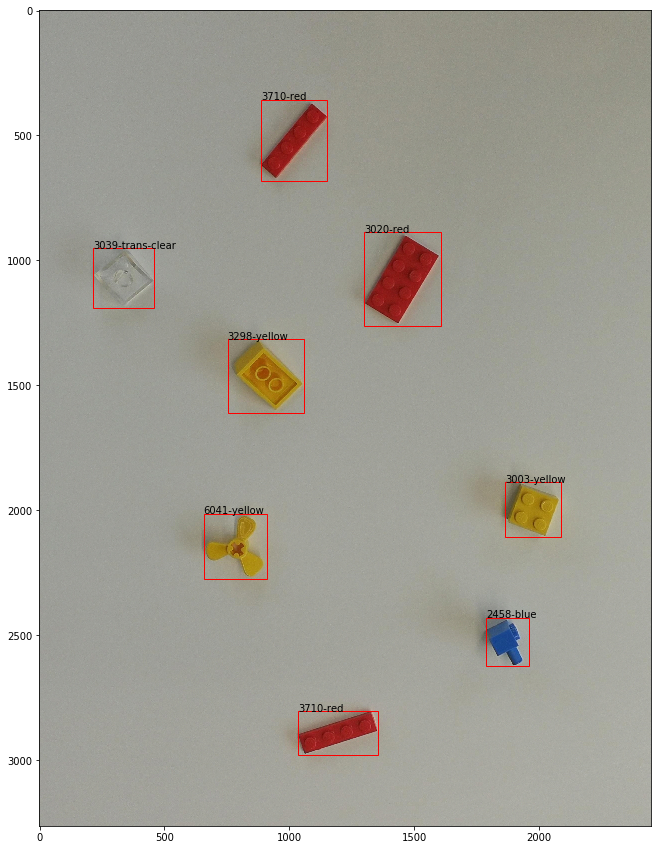

In [208]:
bounding_boxes = list(map(lambda line: list(map(lambda string: float(string), re.findall(only_numbers, line))), open(bbox_path).readlines()))
labels = list(map(lambda line: line.strip('\n'), open(labels_path).readlines()))
display_bounding_boxes(image, bounding_boxes, labels)

In [210]:
def calculate_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

def intersection_over_union_removal(ground_truth_bounding_boxes, predicted_bounding_boxes, threshold=0.5):
    above_threshold = []
    for gt_bbox in ground_truth_bounding_boxes:
        above_threshold.extend(list(filter(lambda boxB: calculate_intersection_over_union(gt_bbox, boxB)>threshold,
                                 predicted_bounding_boxes)))
    return above_threshold

In [176]:
%%time
labels, regions = selectivesearch.selective_search(image, min_size=600, scale=400.0, sigma=1.5)

Wall time: 1min 6s


In [177]:
def w_h_to_x2_y2(box):
    x1, y1 = box[:2]
    x2, y2 = box[:2] + box[2:]
    return x1, y1, x2, y2

In [178]:
def x2_y2_to_w_h(box):
    x1, y1 = box[:2]
    w, h = box[2:] - box[:2]
    return x1, y1, w, h

In [179]:
selective_search_bboxes = list(map(lambda x: w_h_to_x2_y2(np.asarray(x['rect'])), regions))

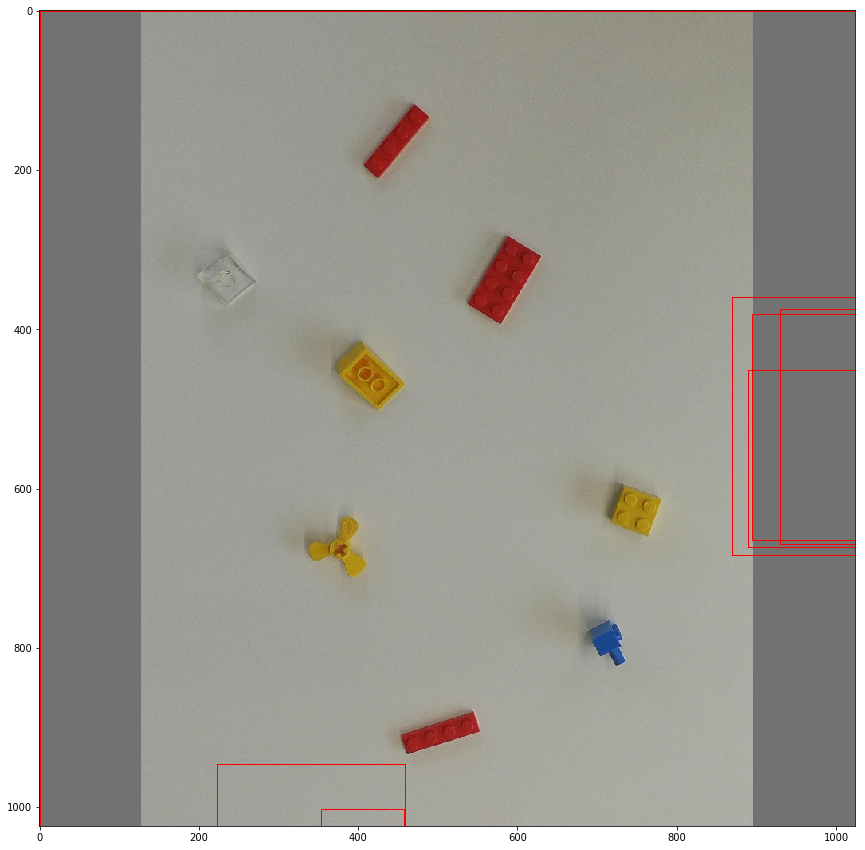

In [217]:
display_bounding_boxes(image=resize_and_pad(image, width=1024, height=1024), bounding_boxes=selective_search_bboxes)

In [181]:
remove_above_threshold = list(filter(lambda x: x2_y2_to_w_h(np.asarray(x))[2] < 500 and x2_y2_to_w_h(np.asarray(x))[3] < 500, selective_search_bboxes))

(128, 0, 128, 0) [272 112 365 214]
[400 112 493 214]
(128, 0, 128, 0) [291 117 361 210]
[419 117 489 210]
(128, 0, 128, 0) [280 119 358 208]
[408 119 486 208]
(128, 0, 128, 0) [278 141 323 211]
[406 141 451 211]
(128, 0, 128, 0) [400 277 505 397]
[528 277 633 397]
(128, 0, 128, 0) [447 282 501 393]
[575 282 629 393]
(128, 0, 128, 0) [ 69 296 144 373]
[197 296 272 373]
(128, 0, 128, 0) [110 314 143 367]
[238 314 271 367]
(128, 0, 128, 0) [409 365 452 393]
[537 365 580 393]
(128, 0, 128, 0) [236 410 336 506]
[364 410 464 506]
(128, 0, 128, 0) [290 427 330 502]
[418 427 458 502]
(128, 0, 128, 0) [272 448 289 465]
[400 448 417 465]
(128, 0, 128, 0) [290 463 305 477]
[418 463 433 477]
(128, 0, 128, 0) [576 583 656 664]
[704 583 784 664]
(128, 0, 128, 0) [630 608 652 660]
[758 608 780 660]
(128, 0, 128, 0) [202 624 285 713]
[330 624 413 713]
(128, 0, 128, 0) [209 680 281 710]
[337 680 409 710]
(128, 0, 128, 0) [565 755 609 825]
[693 755 737 825]
(128, 0, 128, 0) [546 764 605 821]
[674 764 73

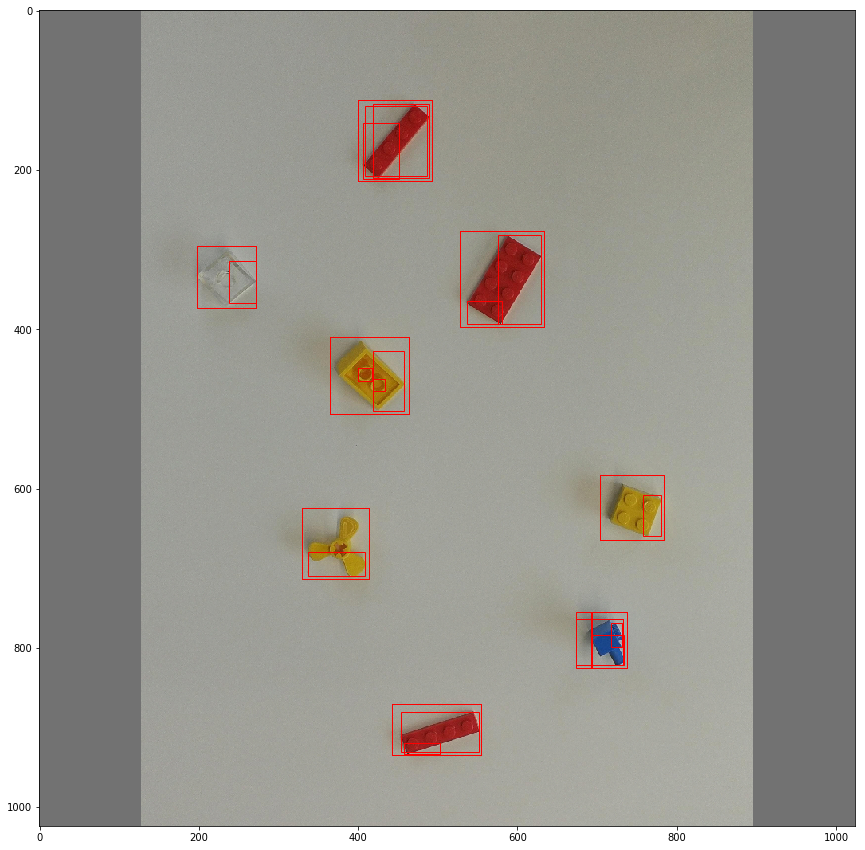

In [323]:
resized_image, scale, padding = resize_and_pad(image, width=1024, height=1024)
bounding_boxes = list(map(lambda bbox: correct_bounding_boxes(np.array(bbox), scale, scale, padding), remove_above_threshold))
display_bounding_boxes(resized_image, bounding_boxes)

In [275]:
non_maxed_suppression = intersection_over_union_removal(bounding_boxes, non_max_suppression_fast(np.asarray(remove_above_threshold), overlapThresh=0.1))

In [321]:
def correct_bounding_boxes(box, scale_x=None, scale_y=None, padding=None):
    assert isinstance(box, np.ndarray)
    if scale_x:
        box[np.array([0, 2])] = np.multiply(box[np.array([0, 2])], scale_x) 
    if scale_y:
        box[np.array([1, 3])] = np.multiply(box[np.array([1, 3])], scale_y)
    left, top, right, bottom = padding    
    box[0] = box[0] + left   
    box[1] = box[1] + top    
    box[2] = box[2] + right
    box[3] = box[3] + bottom  
    return box

(128, 0, 128, 0) [315 871 426 935]
[443 871 554 935]
(128, 0, 128, 0) [272 112 365 214]
[400 112 493 214]
(128, 0, 128, 0) [400 277 505 397]
[528 277 633 397]
(128, 0, 128, 0) [576 583 656 664]
[704 583 784 664]
(128, 0, 128, 0) [565 755 609 825]
[693 755 737 825]
(128, 0, 128, 0) [202 624 285 713]
[330 624 413 713]
(128, 0, 128, 0) [ 69 296 144 373]
[197 296 272 373]
(128, 0, 128, 0) [236 410 336 506]
[364 410 464 506]


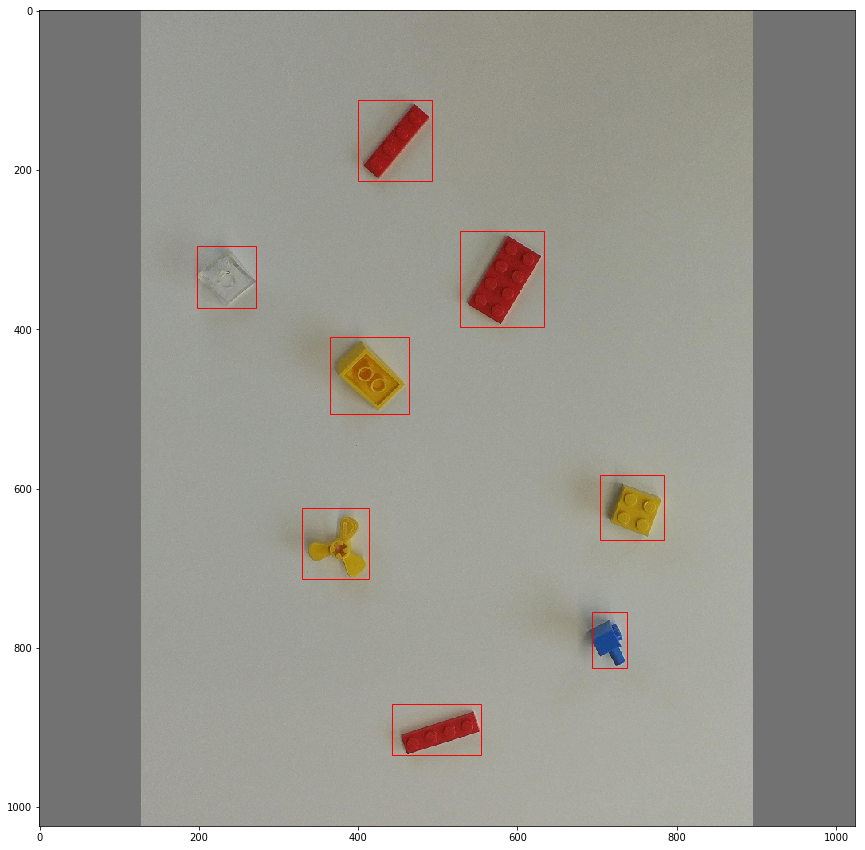

In [322]:
resized_image, scale, padding = resize_and_pad(image, width=1024, height=1024)
bounding_boxes = list(map(lambda bbox: correct_bounding_boxes(np.array(bbox), scale, scale, padding), non_maxed_suppression))
display_bounding_boxes(resized_image, bounding_boxes)

In [192]:
def cut_out_bounding_box(image, bounding_box, is_square=False):
    x1, y1, x2, y2 = bounding_box
    if is_square:
        window_size = abs(y2 - y1) if abs(y2 - y1) > abs(x2 - x1) else abs(x2 - x1)
        return image[y1:y1+window_size, x1:x1+window_size, :]
    return image[y1:y2, x1:x2, :]  

In [213]:
def preprocess(image, shape):    
    preproccesed = helpers.pipeline(image, shape=shape, smoothing=0.1, with_hog_attached=True,
                                    with_dominant_color_attached=True, pixels_per_cell=(shape[0]/8, shape[0]/8),
                                    cells_per_block=(8, 8), debug=True)
    preproccesed = preprocessing.scale(preproccesed, with_mean=False)   
    return preproccesed

def classify(image, classifier):
    prediction = classifier.predict_proba([image])
    return prediction[0]

In [194]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-256W.joblib")
shape = (256, 256)

In [153]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-128W.joblib")
shape = (128, 128)

In [156]:
classifier = joblib.load(r"D:\Projects\LEGO Vision\Classification\Final models\SVM\SVM-3200-64W.joblib")
shape = (64, 64)

In [195]:
label_lookup = sorted([line.split('\t')[0] for line in open(r"D:\LEGO Vision Datasets\Detection\Natural Data_output\class_map.txt").readlines()[1:]])
label_lookup

['2458-blue',
 '3003-yellow',
 '3020-red',
 '3039-trans-clear',
 '3298-yellow',
 '3710-red',
 '6041-yellow']

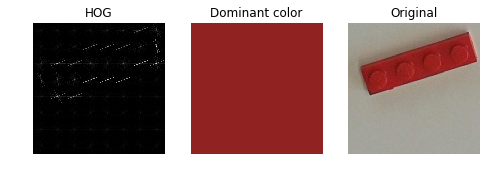

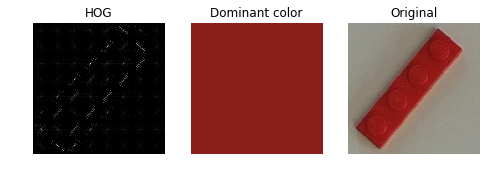

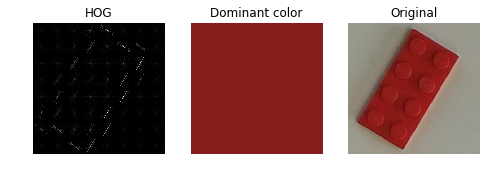

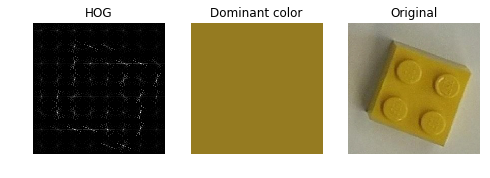

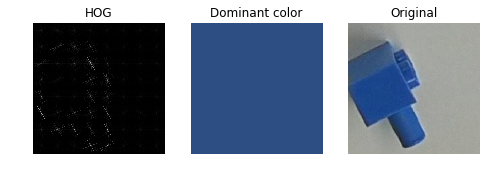

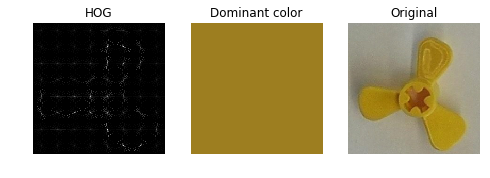

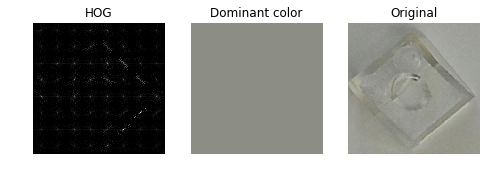

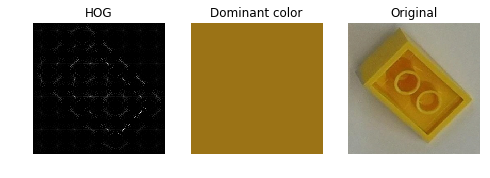

In [214]:
scores = []
labels = []
for bounding_box in non_maxed_suppression:
    sub_image = cut_out_bounding_box(image, bounding_box, is_square=True)
    prediction = classify(preprocess(sub_image, shape), classifier)
    scores.append(max(prediction))
    labels.append(label_lookup[prediction.argmax(axis=0)])

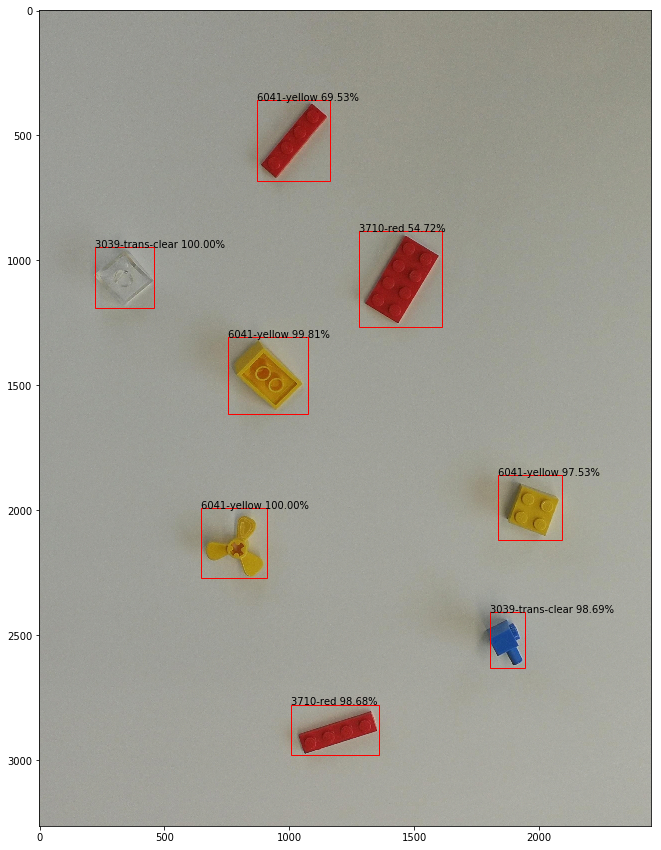

In [203]:
display_bounding_boxes(image, non_maxed_suppression, labels, scores)

In [ ]:
def 